# Automatic Essay Grading and Feedback
 - Patrick Myers, Gaurav Kumar Jindal, Sanchit Sinha, Aniruddha Dave

# Importing Libraries:
 - We first import all necessary libraries for our code.

In [11]:
# import libraries
import warnings
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import math
#nltk.download()
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
nltk.download('stopwords')
nltk.download('punkt')

import matplotlib.pyplot as plt

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

google_colab=False

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Patrick\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Patrick\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
if google_colab:
    # Google Colab stuff
    from google.colab import drive
    drive.mount('/content/drive')

## Data Preprocessing:
 - We establish a class to handle loading, preprocessing, and chunking of our dataset.

In [13]:
class Dataset:
    def __init__(self, path):

        if google_colab:
            self.df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/NLP/data/training_data.csv")
        else:
            self.df = pd.read_csv("training_data.csv")
        self.data = self.df.to_numpy()

        self.stopwords = set(stopwords.words('english'))
        self.essay_id = self.data[:,0]
        self.text = self.data[:,1]
        self.scores = self.data[:,2:8]
        self.new_data = []
        self.new_scores = []
        self.vocab = set()
        self.word_to_id = None

    def preprocess(self):
        for i in range(len(self.essay_id)):
            text = self.text[i].lower()
            text = " ".join([word for word in text.split() if '@' not in word])
            text = word_tokenize(text)
            text = [word for word in text if word not in self.stopwords]
            self.text[i] = text 

    def create_vocab(self):
        for line in self.text:
            for word in line:
                self.vocab.add(word)

        self.vocab = sorted(list(self.vocab))
        self.word_to_id = {word:i for i, word in enumerate(self.vocab)}

    def text_num(self):
        for i, line in enumerate(self.text):
            x = []
            for word in line:
                x.append(self.word_to_id[word])
            self.text[i] = x

    def create_chunks(self):
        for idx in range(len(self.essay_id)):
            ess = self.text[idx]
            n = len(ess)
            self.new_data.append([ess[:n//3]])
            self.new_data.append([ess[n//3:2*n//3]])
            self.new_data.append([ess[2*n//3:]])
            self.new_scores.append(self.scores[idx])
            self.new_scores.append(self.scores[idx])
            self.new_scores.append( self.scores[idx])

import pandas as pd
import nltk
#nltk.download()
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np


dataset = Dataset("/content/drive/My Drive/Colab Notebooks/NLP/data/training_data.csv")
print(dataset.text.shape)
dataset.preprocess()
dataset.create_vocab()
# print(len(dataset.vocab))
# print(dataset.vocab[:10])
# print(dataset.word_to_id['!'])
# dataset.create_chunks()
# print(dataset.new_data.shape)
# print(dataset.text[0])
"""
print(len(dataset.new_data), len(dataset.essay_id))
print("0: ", dataset.new_data[0, 0])
print("1: ", dataset.new_data[1, 0])
print("2: ", dataset.new_data[2, 0])
print(dataset.text[0])
"""

(723,)


'\nprint(len(dataset.new_data), len(dataset.essay_id))\nprint("0: ", dataset.new_data[0, 0])\nprint("1: ", dataset.new_data[1, 0])\nprint("2: ", dataset.new_data[2, 0])\nprint(dataset.text[0])\n'

In [14]:
dataset.text_num()
dataset.create_chunks()
train_text = dataset.new_data

max_len = 0
for row in train_text:
  leng = len(row[0])
  if leng > max_len:
    max_len = leng

train_text = [train_text[i][0] for i in range(len(train_text))]

# Padding with space (0)
for i in range(len(train_text)):
    while len(train_text[i])<=max_len:
        train_text[i].append(0)


train_label = dataset.new_scores
len(train_label)

from sklearn import model_selection
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(train_text, train_label)

train_x = np.array(train_x)
valid_x = np.array(valid_x)
train_y = np.array(train_y)
valid_y = np.array(valid_y)

vocab_len = len(dataset.vocab)

device = torch.device('cuda:0')# if torch.cuda.is_available() else 'cpu')

In [15]:
batch_size=1
def load_category_data(cat, train_x, valid_x, train_y, valid_y):
    if google_colab:
        train_x = torch.from_numpy(np.array(train_x)).to(device)
        train_y = torch.from_numpy(np.array(train_y)[:,cat].astype(float)).to(device)
        valid_x = torch.from_numpy(np.array(valid_x)).to(device)
        valid_y = torch.from_numpy(np.array(valid_y)[:,cat].astype(float)).to(device)
    else:
        train_x = torch.from_numpy(np.array(train_x)).to(torch.int64).to(device)
        train_y = torch.from_numpy(np.array(train_y)[:,cat].astype(float)).to(torch.int64).to(device)
        valid_x = torch.from_numpy(np.array(valid_x)).to(torch.int64).to(device)
        valid_y = torch.from_numpy(np.array(valid_y)[:,cat].astype(float)).to(torch.int64).to(device)

    train_loader = DataLoader(TensorDataset(train_x, train_y), batch_size = 1, shuffle = False)
    valid_loader = DataLoader(TensorDataset(valid_x, valid_y), batch_size = 1, shuffle = False)
    
    return train_loader, valid_loader

## PyTorch LSTM Model:
 - Here is our LSTM model and helper functions for training, validation, and calculating accuracy. We round predictions to the nearest integer in order to determine accuracy.

In [16]:
class LSTM_Model(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_num, output_num, layer_num):
        super().__init__()
        self.vocab_size = vocab_size
        self.layer_num = layer_num
        self.hidden_num = hidden_num
        self.output_num = output_num
            
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_num, num_layers=layer_num)
        self.fc = nn.Linear(hidden_num,output_num)
        self.relu = nn.ReLU()

    def make_hidden(self):
        return (torch.randn(self.layer_num, max_len+1, self.hidden_num).cuda(), torch.randn(self.layer_num, max_len+1, self.hidden_num).cuda())
        
    def forward(self, word_seq, hidden):
        word_emb = self.embedding(word_seq)
        lstm_out, hidden = self.lstm(word_emb, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_num)[-1]
        fc_out = self.fc(lstm_out)
        relu_out = self.relu(fc_out)

        return relu_out, hidden

In [17]:
def get_accuracy(predictions):
    correct = 0
    total = 0
    for batch in predictions:
        for item in batch:
            if int(round(item[0])) == int(item[1]):
                correct += 1
            total += 1
    return correct/total

In [18]:
def train(data_loader, classifier, loss_function, optimizer):
    classifier.train()
    loss = 0
    losses = []
    prediction_list = []
    accuracy = 0
    accuracies = []
    for i, (texts, labels) in enumerate(data_loader):
#         skipping broken data entry
        if texts[0][0] != 3785 or labels != 5:
            if(texts.shape[0] != batch_size):
                break
                
            labels = labels.float().cuda()
            texts = texts.cuda()
            optimizer.zero_grad()

            hidden = rnn_model.make_hidden()
            predictions, hidden = classifier(texts, hidden)
            loss = loss_function(predictions, labels)

            loss.backward()
            optimizer.step()
            losses.append(loss.item()) 
            prediction_list.append([(predictions[i].item(), labels[i].item()) for i in range(len(predictions))])
      
    return prediction_list, sum(losses)/len(losses)

In [19]:
def validation(data_loader, classifier, loss_function):
    classifier.eval()
    loss = 0
    losses = []
    prediction_list = []
    accuracy = 0
    accuracies = []
    for i, (texts, labels) in enumerate(data_loader):
#         skipping broken data entry
        if texts[0][0] != 3785 or labels != 5:
            if(texts.shape[0] != batch_size):
                break
                
            labels = labels.float().cuda()
            texts = texts.cuda()
            
            hidden = rnn_model.make_hidden()
            predictions, hidden = classifier(texts, hidden)
            loss = loss_function(predictions, labels)

            losses.append(loss.item()) 
            prediction_list.append([(predictions[i].item(), labels[i].item()) for i in range(len(predictions))])
            
    return prediction_list, sum(losses)/len(losses)

## Training Our Model:
 - We train six separate models, one for each of the rubric categories, and store their loss, accuracy, and RMSE values in lists.

In [20]:
trn_loss_list = []
val_loss_list = []
trn_acc_list = []
val_acc_list = []
trn_rmse_list = []
val_rmse_list = []

model_list = []

for cat in range(6):
    trn_loss = []
    val_loss = []
    trn_acc = []
    val_acc = []
    trn_rmse = []
    val_rmse = []
    
    
    train_loader, valid_loader = load_category_data(cat, train_x, valid_x, train_y, valid_y)
    n_vocab = vocab_len
    n_embed = 100
    n_hidden = 32
    n_output = 1
    n_layers = 2

    rnn_model = LSTM_Model(n_vocab, n_embed, n_hidden, n_output, n_layers)
    rnn_model.cuda()
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(rnn_model.parameters(), lr=.0001)

    epochs = 10

    training_losses = []
    validation_losses = []
    for epoch in range(0, epochs):
        print("category:", cat, "epoch:", epoch + 1)
        train_predictions, training_loss = train(train_loader, rnn_model, loss_function, optimizer)
        validation_predictions, validation_loss = validation(valid_loader, rnn_model, loss_function)
        print("training_loss:", training_loss)
        print("validation_loss:", validation_loss)
        trn_loss.append(training_loss)
        val_loss.append(validation_loss)

        training_accuracy = get_accuracy(train_predictions)
        validation_accuracy = get_accuracy(validation_predictions)
        print("train_accuracy:", training_accuracy)
        print("validation_accuracy:", validation_accuracy)
        trn_acc.append(training_accuracy)
        val_acc.append(validation_accuracy)

        training_rmse = math.sqrt(mean_squared_error([pred[0][0] for pred in train_predictions], [pred[0][1] for pred in train_predictions]))
        validation_rmse = math.sqrt(mean_squared_error([pred[0][0] for pred in validation_predictions], [pred[0][1] for pred in validation_predictions]))
        print("training_rmse", training_rmse)
        print("validation_rmse", validation_rmse)
        trn_rmse.append(training_rmse)
        val_rmse.append(validation_rmse)
        
        print("\n")
        
    trn_loss_list.append(trn_loss)
    val_loss_list.append(val_loss)
    trn_acc_list.append(trn_acc)
    val_acc_list.append(val_acc)
    trn_rmse_list.append(trn_rmse)
    val_rmse_list.append(val_rmse)
    
    model_list.append(rnn_model)

category: 0 epoch: 1
training_loss: 6.787516865047649
validation_loss: 0.7979272252045888
train_accuracy: 0.09471094710947109
validation_accuracy: 0.3020257826887661
training_rmse 2.605286331418289
validation_rmse 0.8932677233916992


category: 0 epoch: 2
training_loss: 0.5496929801467934
validation_loss: 0.5476000995971388
train_accuracy: 0.498769987699877
validation_accuracy: 0.5322283609576427
training_rmse 0.7414128271649104
validation_rmse 0.7400000674408113


category: 0 epoch: 3
training_loss: 0.5099897414853719
validation_loss: 0.5393421434036574
train_accuracy: 0.5615006150061501
validation_accuracy: 0.5506445672191529
training_rmse 0.7141356609654339
validation_rmse 0.7343991717449826


category: 0 epoch: 4
training_loss: 0.5068431735543172
validation_loss: 0.5519455597207678
train_accuracy: 0.5541205412054121
validation_accuracy: 0.5488029465930019
training_rmse 0.7119291917809052
validation_rmse 0.7429303863473251


category: 0 epoch: 5
training_loss: 0.5152475570970503
val

training_rmse 0.645516250740042
validation_rmse 0.6548075530998541


category: 3 epoch: 6
training_loss: 0.41364426743202876
validation_loss: 0.4376144431223797
train_accuracy: 0.6654366543665436
validation_accuracy: 0.6519337016574586
training_rmse 0.6431518226364472
validation_rmse 0.6615243311261612


category: 3 epoch: 7
training_loss: 0.4168746388707678
validation_loss: 0.4384407489458239
train_accuracy: 0.6648216482164822
validation_accuracy: 0.6519337016574586
training_rmse 0.6456582983520859
validation_rmse 0.6621485859857574


category: 3 epoch: 8
training_loss: 0.414603421586761
validation_loss: 0.4293413471550765
train_accuracy: 0.6654366543665436
validation_accuracy: 0.6556169429097606
training_rmse 0.6438970579072937
validation_rmse 0.655241440682818


category: 3 epoch: 9
training_loss: 0.4068600275569723
validation_loss: 0.42622044165413975
train_accuracy: 0.6672816728167281
validation_accuracy: 0.6519337016574586
training_rmse 0.6378558051896089
validation_rmse 0.652855

## Plotting Results:
 - Here we plot the loss, accuracy, and RMSE results from each of the six models.

In [21]:
index_to_cat = {
    0 : "ideas/content",
    1 : "organization",
    2 : "voice",
    3 : "word choice",
    4 : "sentence fluency",
    5 : "conventions",
             }

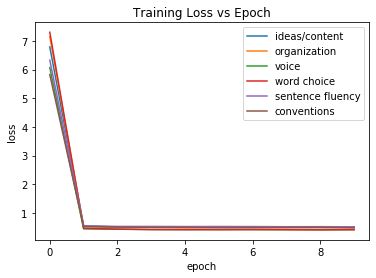

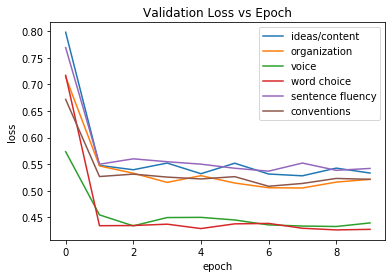

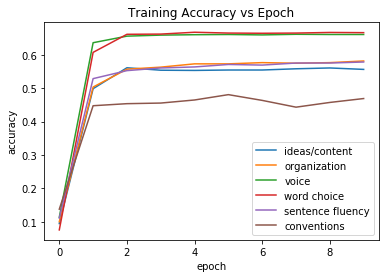

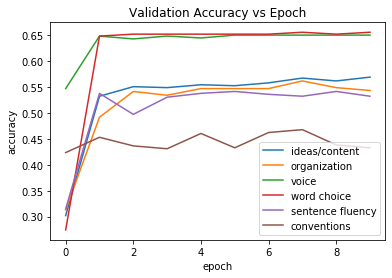

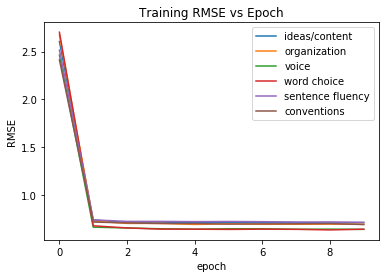

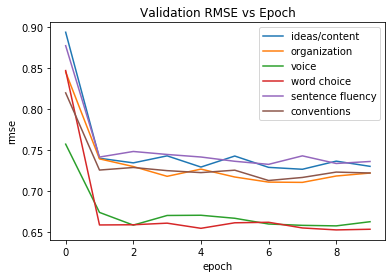

In [22]:
for index in range(6):
    plt.plot(trn_loss_list[index], label=str(index_to_cat[index]))
plt.title("Training Loss vs Epoch")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

for index in range(6):
    plt.plot(val_loss_list[index], label=str(index_to_cat[index]))
plt.title("Validation Loss vs Epoch")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

for index in range(6):
    plt.plot(trn_acc_list[index], label=str(index_to_cat[index]))
plt.title("Training Accuracy vs Epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

for index in range(6):
    plt.plot(val_acc_list[index], label=str(index_to_cat[index]))
plt.title("Validation Accuracy vs Epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

for index in range(6):
    plt.plot(trn_rmse_list[index], label=str(index_to_cat[index]))
plt.title("Training RMSE vs Epoch")
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.legend()
plt.show()

for index in range(6):
    plt.plot(val_rmse_list[index], label=str(index_to_cat[index]))
plt.title("Validation RMSE vs Epoch")
plt.xlabel("epoch")
plt.ylabel("rmse")
plt.legend()
plt.show()


## Grading an Example Essay
 - Here we grade a single essay using the trained models and present our output feedback.

In [32]:
selected_essay_index = 0

data_example = Dataset("/content/drive/My Drive/Colab Notebooks/NLP/data/training_data.csv")
data_example.preprocess()
data_example.text = [data_example.text[selected_essay_index]]
data_example.essay_id = [data_example.essay_id[selected_essay_index]]
data_example.scores = [data_example.scores[selected_essay_index]]
data_example.create_vocab()
data_example.text_num()
data_example.create_chunks()
train_text_example = data_example.new_data

for i in range(len(train_text_example)):
    while len(train_text_example[i][0])<=max_len:
        train_text_example[i][0].append(0)

In [33]:
for cat in range(6):
    print("Category: ", index_to_cat[cat])
    for chunk in range(3):
        hidden = model_list[cat].make_hidden()
        prediction, hidden = model_list[cat](torch.from_numpy(np.array(train_text_example[chunk])).to(torch.int64).to(device), hidden)
        print("Section:", chunk, " Predicted Score:", prediction.item(), " True Score:", data_example.scores[0][cat])
    print("\n")

Category:  ideas/content
Section: 0  Predicted Score: 3.588099718093872  True Score: 4
Section: 1  Predicted Score: 3.5635805130004883  True Score: 4
Section: 2  Predicted Score: 3.639218330383301  True Score: 4


Category:  organization
Section: 0  Predicted Score: 3.6750357151031494  True Score: 4
Section: 1  Predicted Score: 3.901684522628784  True Score: 4
Section: 2  Predicted Score: 3.6916704177856445  True Score: 4


Category:  voice
Section: 0  Predicted Score: 4.0161051750183105  True Score: 4
Section: 1  Predicted Score: 4.017720699310303  True Score: 4
Section: 2  Predicted Score: 3.9705214500427246  True Score: 4


Category:  word choice
Section: 0  Predicted Score: 3.7575244903564453  True Score: 4
Section: 1  Predicted Score: 3.8006322383880615  True Score: 4
Section: 2  Predicted Score: 3.8926503658294678  True Score: 4


Category:  sentence fluency
Section: 0  Predicted Score: 3.7069079875946045  True Score: 4
Section: 1  Predicted Score: 3.415090560913086  True Score: 

## Keras Implementation Using Glove Embedding:
 - Here we provide an alternative implementation using Keras and a Glove embedding.

In [15]:
config = tf.ConfigProto( device_count = {'GPU': 1} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

K.tensorflow_backend._get_available_gpus()

NameError: name 'tf' is not defined

In [19]:
word_embeddings = {}
for i, row in enumerate(open('/content/drive/My Drive/Colab Notebooks/NLP/glove.6B/glove.6B.300d.txt',encoding="utf8")):
    row_val = row.split()
    word_embeddings[row_val[0]] = np.array(row_val[1:])
    
trn_embedding = []
trn_tokens = dataset.vocab
for row in trn_tokens:
    embedd = word_embeddings.get(row,0)
    if embedd != 0:
        trn_embedding.append(embedd.tolist())
    
trn_embedding = np.array(trn_embedding)
print(trn_embedding.shape)    

(10884, 300)


In [0]:
def lstm_model():
    input_layer = layers.Input((max_len+1, ))

    embedding_layer = layers.Embedding(len(trn_embedding), 300, weights=[trn_embedding], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)
    lstm_layer = layers.LSTM(256)(embedding_layer)

    output_layer1 = layers.Dense(64, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.2)(output_layer1)
    output_layer2 = layers.Dense(32, activation="relu")(output_layer1)
    output_layer2 = layers.Dropout(0.2)(output_layer2)
    output_layer3 = layers.Dense(1, activation="relu")(output_layer2)

    model = models.Model(inputs=input_layer, outputs=output_layer3)
    model.compile(optimizer=optimizers.Adam(), loss='mean_squared_error')
    
    return model


In [26]:
trn_loss_list = []
val_loss_list = []
trn_acc_list = []
val_acc_list = []
trn_rmse_list = []
val_rmse_list = []

history_list = []
for cat in range(6):
    trn_loss = []
    val_loss = []
    trn_acc = []
    val_acc = []
    trn_rmse = []
    val_rmse = []

    epochs = 3
    model = lstm_model()
    history = model.fit(train_x, train_y[:,cat], epochs= epochs, verbose=1, 
                        validation_split= 0.2, batch_size= 100)
    
    history_list.append(history)
    train_predictions = model.predict(train_x, batch_size= 100)
    valid_predictions = model.predict(valid_x, batch_size= 100)

    trn_rmse = math.sqrt(mean_squared_error(train_predictions, train_y[:,cat]))
    val_rmse = math.sqrt(mean_squared_error(valid_predictions, valid_y[:,cat]))

    trn_rmse_list.append(trn_rmse)
    val_rmse_list.append(val_rmse)

Train on 1300 samples, validate on 326 samples
Epoch 1/5
1300/1300 [==============================] - 6s 5ms/step - loss: 6.8839 - val_loss: 0.5631
Epoch 2/5
1300/1300 [==============================] - 5s 4ms/step - loss: 1.6220 - val_loss: 0.5819
Epoch 3/5
1300/1300 [==============================] - 5s 4ms/step - loss: 1.3622 - val_loss: 0.5630
Epoch 4/5
1300/1300 [==============================] - 5s 4ms/step - loss: 1.3552 - val_loss: 0.5843
Epoch 5/5
1300/1300 [==============================] - 5s 4ms/step - loss: 1.1593 - val_loss: 0.6190
Train on 1300 samples, validate on 326 samples
Epoch 1/5
1300/1300 [==============================] - 6s 5ms/step - loss: 3.7568 - val_loss: 0.7731
Epoch 2/5
1300/1300 [==============================] - 5s 4ms/step - loss: 1.2071 - val_loss: 0.5830
Epoch 3/5
1300/1300 [==============================] - 5s 4ms/step - loss: 1.1515 - val_loss: 0.5464
Epoch 4/5
1300/1300 [==============================] - 5s 4ms/step - loss: 1.0946 - val_loss: 0.57

In [0]:
def plot_history(history):
    train_loss_history = history.history['loss']
    val_loss_history = history.history['val_loss']

    train_acc_history = history.history['acc']
    val_acc_history = history.history['val_acc']
    epochs = range(len(train_loss_history))
    
    # plot
    plt.plot(epochs, val_loss_history, label="testing_loss")
    plt.plot(epochs, train_loss_history, label="training_loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(loc = 'best')
    plt.title("Loss vs Epochs")
    plt.show()

    plt.plot(epochs, val_acc_history, label="testing_acc")
    plt.plot(epochs, train_acc_history, label="training_acc")
    plt.xlabel("epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc = 'best')
    plt.title("Accuracy vs Epochs")
    plt.show()


In [0]:
for index in range(6):
    plt.plot(trn_rmse_list[index], label=str(index_to_cat[index]))
plt.title("Training RMSE vs Epoch")
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.legend()
plt.show()

for index in range(6):
    plt.plot(val_rmse_list[index], label=str(index_to_cat[index]))
plt.title("Validation RMSE vs Epoch")
plt.xlabel("epoch")
plt.ylabel("rmse")
plt.legend()
plt.show()